# Integrantes

* Centeno Amado Eduardo
* Orozpe Frias Erick Adrian
* Pineda Gaona Maricruz
* Rodríguez Teodores Armando Jair
* Velasco Martell Dayra

# Bibliotecas

In [125]:
#Bibliotecas
import os
import pandas as pd
import numpy as np

#KS test, ji-cuadrada
from scipy.stats import ks_2samp, chi2_contingency

#Graficas
import matplotlib.pyplot as plt
from matplotlib import cycler
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Valores atipicos
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.mcd import MCD

#Valores ausentes
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [144]:
# Configurar Paleta
PALETA = sns.color_palette("flare")
sns.set_theme(style="whitegrid", palette=PALETA)   # Seaborn global
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["axes.prop_cycle"] = cycler(color=PALETA.as_hex())  # Matplotlib global

# Cargar Dataset

In [2]:
def ruta(folder, file, user='Wsm-erick', main='Diplomado-Ciencia-de-Datos/refs/heads/main'):
    return os.path.join('https://raw.githubusercontent.com', user, main, folder, file)

In [3]:
url = ruta('Modulo-I/Datasets', 'wine_quality.csv')

df = pd.read_csv(url, encoding='utf-8')
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3            NaN              0.28         0.56             1.9      0.075   
4            7.4              0.70          NaN             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality type  
0      9.4      5.0  red  
1      9.8      5.0  red  
2      9.8      5.0  red  
3      9.8      6.0  NaN  
4      9.4      5.0  red

## 1.- Investiga a qué se refiere cada variable del conjunto de datos y sus valores normales de referencia.

Se encontró la siguiente informacion referente a los valores normales para cada una de las variables. Con base en esta informacion, se tomara la decision sobre el tratado de los valores atipicos que se lleguen a encontrar en la base.

In [4]:
url = ruta('Modulo-I/Datasets', 'Variables_del_vino.csv')

description = pd.read_csv(url, encoding='utf-8')
description

Variable                          Valor normal / típico  \
0          fixed acidity  4.0 – 15.0 g/dm³ (tinto más ácido que blanco)   
1       volatile acidity                              0.12 – 1.10 g/dm³   
2            citric acid                                0.0 – 1.0 g/dm³   
3         residual sugar        0.6 – 65.0 g/dm³ (más en vinos blancos)   
4              chlorides                            0.009 – 0.346 g/dm³   
5    free sulfur dioxide               1 – 72 mg/dm³ (mayor en blancos)   
6   total sulfur dioxide              6 – 440 mg/dm³ (mayor en blancos)   
7                density                          0.9900 – 1.0040 g/cm³   
8                     pH                                      2.9 – 3.9   
9              sulphates                              0.22 – 1.08 g/dm³   
10               alcohol                               8.0 – 14.9 % vol   
11               quality               3 – 9 (según escala del dataset)   
12                  type                                'red' o 'white'   

                                    Descripción breve  
0                  Ácidos no volátiles como tartárico  
1                  Ácidos volátiles (como el acético)  
2                               Contribuye a frescura  
3                   Azúcar restante tras fermentación  
4                             Indica presencia de sal  
5                SO₂ libre, protección antimicrobiana  
6                       Total de SO₂ (libre + ligado)  
7                    Relacionado con azúcar y alcohol  
8      Acidez, vinos blancos suelen tener pH más bajo  
9                         Estabilizador y conservante  
10  Mayor alcohol suele estar asociado con mejor c...  
11                    Calificación subjetiva del vino  
12                           Tipo de vino (categoría)

In [5]:
valores_tipicos = {x: None for x in set(description['Variable'])-set({'type'})}

print(list(valores_tipicos.keys()))

['citric acid', 'total sulfur dioxide', 'quality', 'residual sugar', 'density', 'free sulfur dioxide', 'chlorides', 'pH', 'fixed acidity', 'sulphates', 'alcohol', 'volatile acidity']


In [6]:
valores_tipicos = {
    'fixed acidity': (4,15,'g/dm³'),
    'volatile acidity': (0.12,1.1,'g/dm³'),
    'citric acid': (0,1,'g/dm³'),
    'residual sugar': (0.6,65,'g/dm³'),
    'chlorides': (0.009,0.346,'g/dm³'),
    'free sulfur dioxide': (1,72,'mg/dm³'),
    'total sulfur dioxide': (6,440,'mg/dm³'),
    'density': (0.99,1.0040,'g/cm³'),
    'pH': (2.9,3.9,'-'),
    'sulphates': (0.22,1.08,'g/dm³'),
    'alcohol': (8,14.9,'vol'),
    'quality': (3,9,'-')
}

In [7]:
def f_tip(x: float, xmin: float, xmax: float):
  return 1 if x >= xmin and x <= xmax else 0

N = df.shape[0]
data = []
for x, (xmin, xmax, unidad) in valores_tipicos.items():
  n = df[x].apply(lambda y: f_tip(y, xmin, xmax)).sum()
  nulos = df[x].isna().sum()
  data.append([x, unidad, xmin, xmax, nulos, n, N-n-nulos])

df_val_atipicos = pd.DataFrame(data=data, columns=['Variable', 'Unidad', 'Límite Inf', 'Límite Sup', 'Valores Ausentes', 'Valores Típicos', 'Valores Atípicos'])
display(df_val_atipicos)

Variable  Unidad  Límite Inf  Límite Sup  Valores Ausentes  \
0          fixed acidity   g/dm³       4.000      15.000               995   
1       volatile acidity   g/dm³       0.120       1.100               949   
2            citric acid   g/dm³       0.000       1.000               454   
3         residual sugar   g/dm³       0.600      65.000               200   
4              chlorides   g/dm³       0.009       0.346                 0   
5    free sulfur dioxide  mg/dm³       1.000      72.000               138   
6   total sulfur dioxide  mg/dm³       6.000     440.000               744   
7                density   g/cm³       0.990       1.004                 0   
8                     pH       -       2.900       3.900               180   
9              sulphates   g/dm³       0.220       1.080               626   
10               alcohol     vol       8.000      14.900               183   
11               quality       -       3.000       9.000               591   

    Valores Típicos  Valores Atípicos  
0              5497                 5  
1              5517                31  
2              6042                 1  
3              6296                 1  
4              6479                18  
5              6267                92  
6              5753                 0  
7              6149               348  
8              6238                79  
9              5836                35  
10             6314                 0  
11             5906                 0

In [8]:
print("Valores atípicos con respecto a los valores normales de la variable:", df_val_atipicos['Valores Atípicos'].sum())

Valores atípicos con respecto a los valores normales de la variable: 610


## 2.- ¿Existen valores atípicos? ¿Valores ausentes?

Sí, como vemos en las celdas anteriores si hay valores ausentes y valores atípicos. A continuación vamos a revisar más a detalle los valores ausentes e imputaremos por el método de MICE los valores nulos para poder revisar los valores atípicos, cuando el dataset no contenga valores nulos.

In [9]:
var_cat = ["type"]
var_num = list(set(df.columns) - set(var_cat))

In [10]:
print('Variables categóricas:', var_cat[0],
    '\n\n'+'Variables numéricas:', ', '.join(var_num))

Variables categóricas: type 

Variables numéricas: citric acid, total sulfur dioxide, quality, residual sugar, density, free sulfur dioxide, chlorides, pH, fixed acidity, sulphates, alcohol, volatile acidity


In [11]:
def is_na_df(df):
    #Establecemos el resumen de NAs por columna
    na_summary = (
        df.isna().sum()
        .reset_index()
        .rename(columns={"index": "columna", 0: "n_missing"})
    )

    #Tomamos totales y prporciones
    na_summary["total"] = len(df)
    na_summary["prop_missing"] = na_summary["n_missing"] / na_summary["total"]
    na_summary["prop_original"] = 1 - na_summary["prop_missing"]

    #Filtramos solo columnas con al menos 1 NA
    na_summary = na_summary[na_summary["n_missing"] > 0].reset_index(drop=True)

    #Agregamos fila resumen global
    total_missing = df.isna().sum().sum()
    total_elements = df.size
    prop_missing_global = total_missing / total_elements
    prop_original_global = 1 - prop_missing_global

    resumen = pd.DataFrame({
        "columna": ["TOTAL"],
        "n_missing": [total_missing],
        "total": [total_elements],
        "prop_missing": [prop_missing_global],
        "prop_original": [prop_original_global]
    })

    #Creamos la tabla
    na_summary = pd.concat([na_summary, resumen], ignore_index=True)

    return na_summary

In [12]:
is_na_df(df)

columna  n_missing  total  prop_missing  prop_original
0          fixed acidity        995   6497      0.153148       0.846852
1       volatile acidity        949   6497      0.146067       0.853933
2            citric acid        454   6497      0.069878       0.930122
3         residual sugar        200   6497      0.030783       0.969217
4    free sulfur dioxide        138   6497      0.021241       0.978759
5   total sulfur dioxide        744   6497      0.114514       0.885486
6                     pH        180   6497      0.027705       0.972295
7              sulphates        626   6497      0.096352       0.903648
8                alcohol        183   6497      0.028167       0.971833
9                quality        591   6497      0.090965       0.909035
10                  type        800   6497      0.123134       0.876866
11                 TOTAL       5860  84461      0.069381       0.930619

Obtenemos que 10 variables cuentan con valores ausentes. Se representa en la siguiente tabla el numero de valores ausentes por variable y la proporcion que representan.

Realizaremos dos metodos de imputacion con el fin de poder determinar cual es el mas conveniente en cuanto a la preservacion de las distribuciones.

### Imputación en cadena (MICE)

In [13]:
def evaluate_imputation(df_original, df_imputed, vars_num=None, vars_cat=None):
    resultados = []

    # KS test en variables numéricas
    if vars_num:
        for col in vars_num:
            orig = df_original[col].dropna()
            imp = df_imputed[col]
            stat, pval = ks_2samp(orig, imp)
            resultados.append({
                "Variable": col,
                "Tipo": "Numérica",
                "Prueba": "KS test",
                "Estadístico": stat,
                "p-value": pval
            })

    # Chi-cuadrada en variables categóricas
    if vars_cat:
        for col in vars_cat:
            orig_counts = df_original[col].value_counts(dropna=True, normalize=True)
            imp_counts = df_imputed[col].value_counts(normalize=True)

            categories = list(set(orig_counts.index) | set(imp_counts.index))
            observed = np.array([
                [orig_counts.get(cat, 0), imp_counts.get(cat, 0)]
                for cat in categories
            ])
            chi2, pval, _, _ = chi2_contingency(observed.T)
            resultados.append({
                "Variable": col,
                "Tipo": "Categórica",
                "Prueba": "Chi-cuadrada",
                "Estadístico": chi2,
                "p-value": pval
            })

    return pd.DataFrame(resultados)

In [14]:
def impute_mice(df, vars_num, vars_cat, random_state=1989, max_iter=1000):
    df_copy = df.copy()

    # Convertir categóricas a códigos numéricos temporales
    cat_maps = {}
    for col in vars_cat:
        df_copy[col] = df_copy[col].astype("category")
        cat_maps[col] = dict(enumerate(df_copy[col].cat.categories))
        df_copy[col] = df_copy[col].cat.codes.replace(-1, np.nan)

    # IterativeImputer trabaja sobre todo el DF
    imputer = IterativeImputer(random_state=random_state, max_iter=max_iter)
    imputed_array = imputer.fit_transform(df_copy)
    imputed_df = pd.DataFrame(imputed_array, columns=df_copy.columns, index=df_copy.index)

    # Redondear categóricas y devolver a etiquetas originales
    for col in vars_cat:
        imputed_df[col] = imputed_df[col].round().astype(int)
        imputed_df[col] = imputed_df[col].map(cat_maps[col])

    reporte = evaluate_imputation(df, imputed_df, vars_num, vars_cat)
    return imputed_df, reporte

In [15]:
micer = impute_mice(df, var_num, var_cat)

In [16]:
display(micer[0], micer[1])

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          7.400000          0.700000     0.000000        1.900000      0.076   
1          7.800000          0.880000     0.000000        2.600000      0.098   
2          7.800000          0.760000     0.040000        2.300000      0.092   
3         10.178140          0.280000     0.560000        1.900000      0.075   
4          7.400000          0.700000     0.117625        1.900000      0.076   
...             ...               ...          ...             ...        ...   
6492       6.371783          0.210000     0.290000        1.600000      0.039   
6493       6.500478          0.320000     0.360000        8.000000      0.047   
6494       6.500000          0.240000     0.190000        3.349322      0.041   
6495       5.500000          0.290672     0.300000        1.100000      0.022   
6496       6.000000          0.272791     0.380000        0.800000      0.020   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
6492                 24.0                  92.0  0.99114  3.27       0.50   
6493                 57.0                 168.0  0.99490  3.15       0.46   
6494                 30.0                 111.0  0.99254  2.99       0.46   
6495                 20.0                 110.0  0.98869  3.34       0.38   
6496                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol   quality   type  
0         9.4  5.000000    red  
1         9.8  5.000000    red  
2         9.8  5.000000    red  
3         9.8  6.000000    red  
4         9.4  5.000000    red  
...       ...       ...    ...  
6492     11.2  6.000000  white  
6493      9.6  5.000000  white  
6494      9.4  5.485587  white  
6495     12.8  7.000000  white  
6496     11.8  6.000000  white  

[6497 rows x 13 columns]

Variable        Tipo        Prueba  Estadístico   p-value
0            citric acid    Numérica       KS test     0.007881  0.988915
1   total sulfur dioxide    Numérica       KS test     0.010920  0.854591
2                quality    Numérica       KS test     0.029328  0.009508
3         residual sugar    Numérica       KS test     0.004566  1.000000
4                density    Numérica       KS test     0.000000  1.000000
5    free sulfur dioxide    Numérica       KS test     0.001406  1.000000
6              chlorides    Numérica       KS test     0.000000  1.000000
7                     pH    Numérica       KS test     0.004205  1.000000
8          fixed acidity    Numérica       KS test     0.016022  0.423044
9              sulphates    Numérica       KS test     0.021906  0.101626
10               alcohol    Numérica       KS test     0.002589  1.000000
11      volatile acidity    Numérica       KS test     0.022041  0.107134
12                  type  Categórica  Chi-cuadrada     0.000000  1.000000

Realizando la prueba de KS obtenemos que la mayoría de las variables tienen un p-value mayor que 0.05 a excepecion de una, la variable quality. De igual manera, con este metodo de imputacion ya no presentamos ningun valor ausente.

Sin embargo, debido a que una variable no paso la prueba de KS, realizaremos otro metodo de imputacion con el fin de poder ver cual de los dos nos arroja mejores resultados.

In [17]:
is_na_df(micer[1])

columna  n_missing  total  prop_missing  prop_original
0   TOTAL          0     65           0.0            1.0

In [18]:
imputed_df = micer[0]

In [19]:
imputed_df.describe(include = "all")

fixed acidity  volatile acidity  citric acid  residual sugar  \
count     6497.000000       6497.000000  6497.000000     6497.000000   
unique            NaN               NaN          NaN             NaN   
top               NaN               NaN          NaN             NaN   
freq              NaN               NaN          NaN             NaN   
mean         7.215580          0.340131     0.318424        5.443155   
std          1.272535          0.158513     0.141323        4.749903   
min          3.800000         -0.261265    -0.282880       -3.297837   
25%          6.400000          0.230000     0.250000        1.800000   
50%          7.000000          0.295000     0.310000        3.100000   
75%          7.700000          0.410000     0.390000        8.100000   
max         15.900000          1.580000     1.660000       65.800000   

          chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count   6497.000000          6497.000000           6497.000000  6497.000000   
unique          NaN                  NaN                   NaN          NaN   
top             NaN                  NaN                   NaN          NaN   
freq            NaN                  NaN                   NaN          NaN   
mean       0.056034            30.528763            115.376127     0.994697   
std        0.035034            17.639884             55.591614     0.002999   
min        0.009000            -0.813248            -19.857417     0.987110   
25%        0.038000            17.000000             78.000000     0.992340   
50%        0.047000            29.000000            118.000000     0.994890   
75%        0.065000            41.000000            154.108606     0.996990   
max        0.611000           289.000000            440.000000     1.038980   

                 pH    sulphates      alcohol      quality   type  
count   6497.000000  6497.000000  6497.000000  6497.000000   6494  
unique          NaN          NaN          NaN          NaN      2  
top             NaN          NaN          NaN          NaN  white  
freq            NaN          NaN          NaN          NaN   4897  
mean       3.218443     0.531498    10.494635     5.816498    NaN  
std        0.160206     0.145053     1.188895     0.844550    NaN  
min        2.720000     0.220000     8.000000     3.000000    NaN  
25%        3.110000     0.440000     9.500000     5.000000    NaN  
50%        3.210000     0.510000    10.300000     6.000000    NaN  
75%        3.320000     0.600000    11.300000     6.000000    NaN  
max        4.010000     2.000000    14.900000     9.000000    NaN

### Diferencias por cada Imputación

In [403]:
mice_aux = micer[1].copy()
randomforest = pd.read_csv('~/Downloads/randomforest.csv', index_col='Unnamed: 0')

var_order = randomforest['Variable']

randomforest.set_index('Variable', inplace=True)
mice_aux.set_index('Variable', inplace=True)

randomforest = randomforest.filter(['p-value'])
mice_aux = mice_aux.filter(['p-value'])

randomforest.rename(columns={'p-value': 'randomforest'}, inplace=True)
mice_aux.rename(columns={'p-value': 'mice'}, inplace=True)

merged = pd.merge(
    randomforest, mice_aux,
    left_index=True,
    right_index=True,
    how="inner"
)

In [404]:
merged

randomforest      mice
Variable                                    
fixed acidity             0.148284  0.423044
free sulfur dioxide       1.000000  1.000000
volatile acidity          0.213624  0.107134
chlorides                 1.000000  1.000000
pH                        1.000000  1.000000
alcohol                   1.000000  1.000000
residual sugar            0.999994  1.000000
density                   1.000000  1.000000
citric acid               0.960481  0.988915
sulphates                 0.140607  0.101626
quality                   0.013971  0.009508
total sulfur dioxide      0.998890  0.854591
type                      1.000000  1.000000

### Atípicos

In [422]:
class analyze:
    # Inicializamos la clase
    def __init__(self, df, num_vars, cat_vars):
        self.df = df
        self.num_vars = num_vars
        self.cat_vars = cat_vars

    #Método para graficar variables numéricas (cada una en figura independiente)
    def plot_num(self):
        for var in self.num_vars:
            fig = make_subplots(rows=1, cols=2, subplot_titles=(f"{var} - Boxplot", f"{var} - Histograma"))

            # Boxplot
            fig.add_trace(
                go.Box(y=self.df[var], name="Boxplot", marker_color="#008080"),
                row=1, col=1
            )

            # Histograma
            fig.add_trace(
                go.Histogram(x=self.df[var], name="Histograma",
                             #marker_color="#00a77d", 
                             #marker_color='#722F37',
                             marker_color="rgba(114, 47, 55, 0.5)",  # burdeos con 50% transparencia
                             nbinsx=50,
                             histnorm='probability density'),
                row=1, col=2
            )

            fig.update_layout(title_text=f"Variable numérica: {var}", height=400, width=800)
            fig.show()

    #Método para graficar variables categóricas
    def plot_cat(self):
        n = len(self.cat_vars)
        cols = 2
        rows = (n + 1) // cols if n > 1 else 1

        fig = make_subplots(
            rows=rows, cols=cols,
            specs=[[{'type':'domain'}]*cols for _ in range(rows)],
            subplot_titles=self.cat_vars
        )

        for i, var in enumerate(self.cat_vars):
            row = i // cols + 1
            col = i % cols + 1

            value_counts = self.df[var].value_counts()
            labels = value_counts.index.astype(str)
            values = value_counts.values

            wine_palette = [
                "#722F37", "#B85042", "#E6AF2E", "#F6D55C", "#F4A7B9",
                "#2F4F4F", "#8D6E63", "#A1887F", "#D7CCC8", "#795548"
            ]
            
            fig.add_trace(
                go.Pie(
                    labels=labels, 
                    values=values, 
                    name=var, 
                    textinfo='percent+label',
                    marker=dict(colors=wine_palette)
                ),
                row=row, col=col
            )

            #fig.add_trace(
            #    go.Pie(labels=labels, values=values, name=var, textinfo='percent+label'),
            #    row=row, col=col
            #)

        fig.update_layout(title_text="Variables Categóricas", height=400*rows)
        fig.show()

    #Método para graficar la matriz de correlación de numéricas
    def corr_matrix(self, color):
        corr_matrix = self.df[self.num_vars].corr()

        fig = go.Figure(data=go.Heatmap(
            z=corr_matrix.values,
            x=corr_matrix.columns,
            y=corr_matrix.columns,
            colorscale=color,
            text=corr_matrix.round(1).values,      # valores de correlación con 1 decimal
            texttemplate="%{text}",                # mostrar texto en cada celda
            textfont={"size":10, "color":"black"}  # estilo de fuente
            ))

        fig.update_layout(
            title='Matriz de Correlación',
            width=800,
            height=600
        )

        fig.show()

In [196]:
analisis = analyze(imputed_df, var_num, var_cat)

Exploración de distribución de cada variable para la detección de valores atípicos (primer acercamiento).

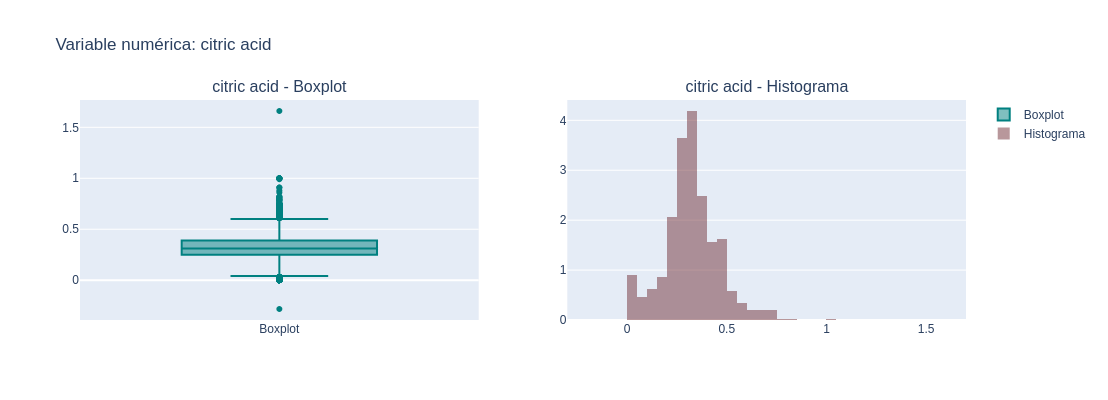

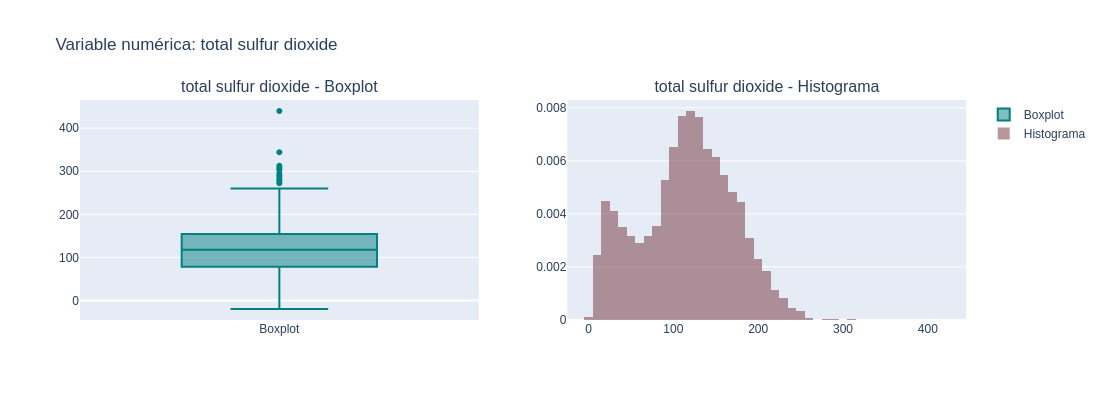

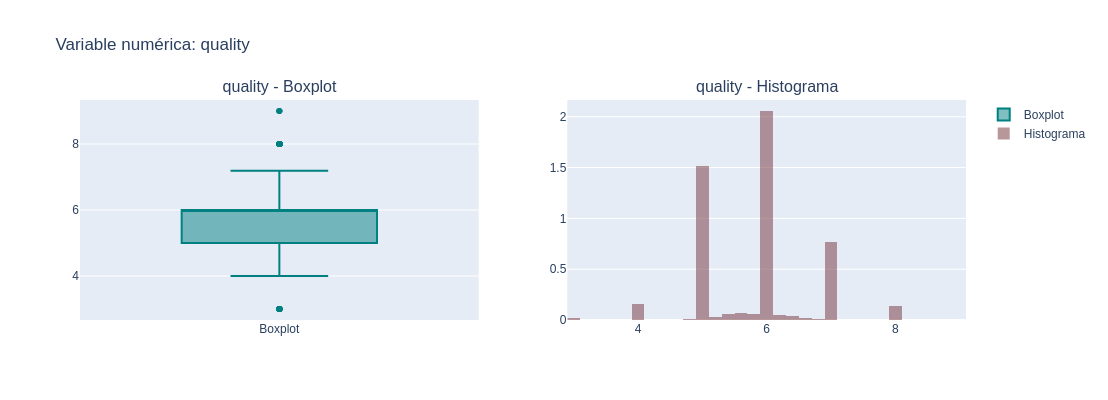

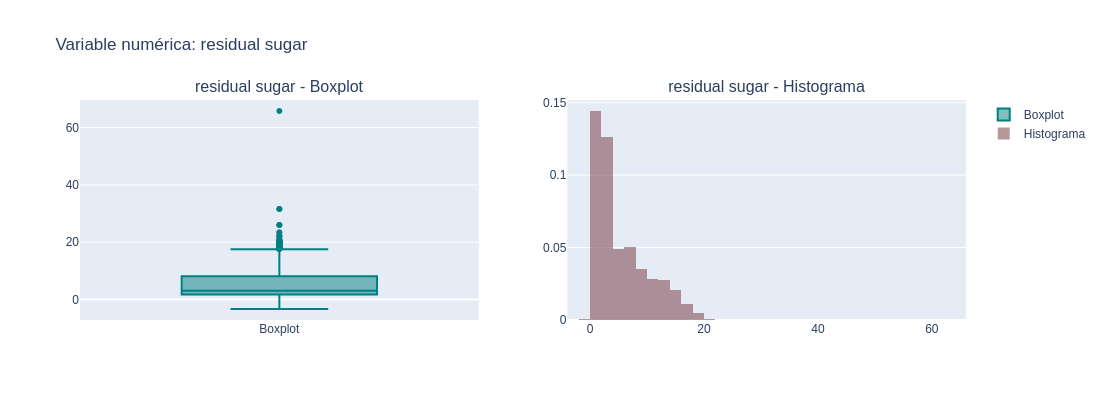

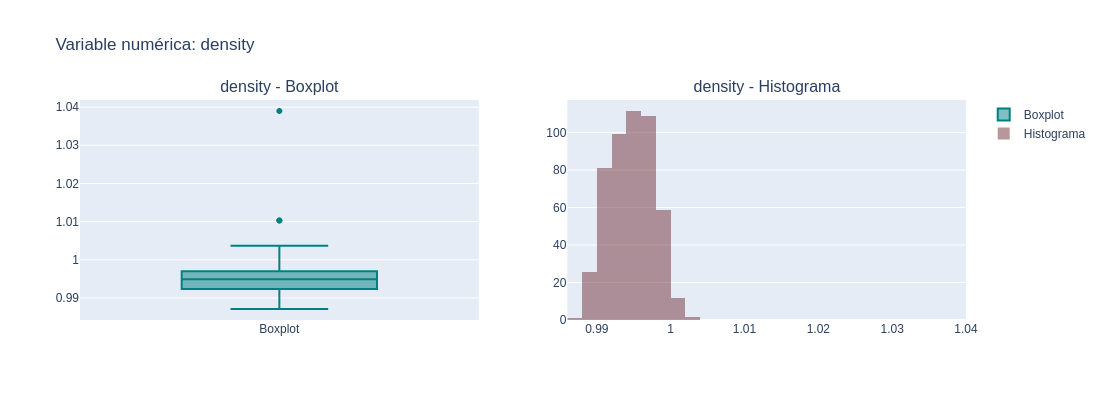

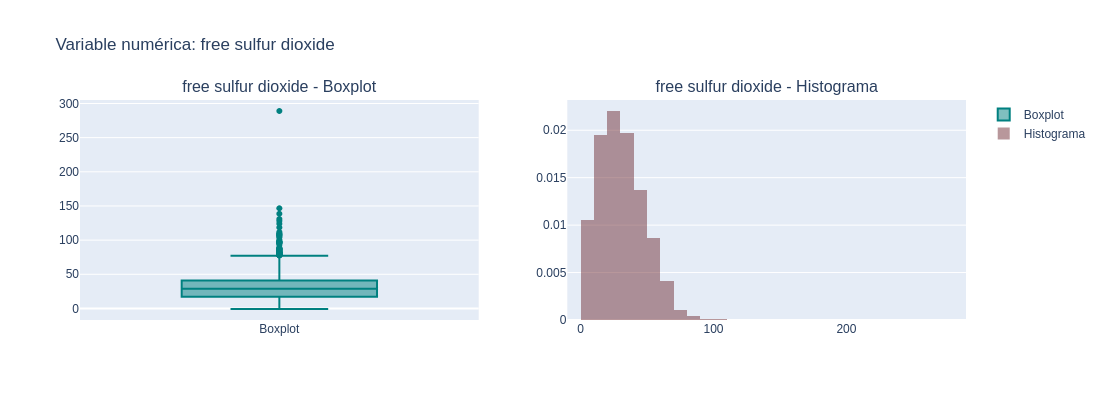

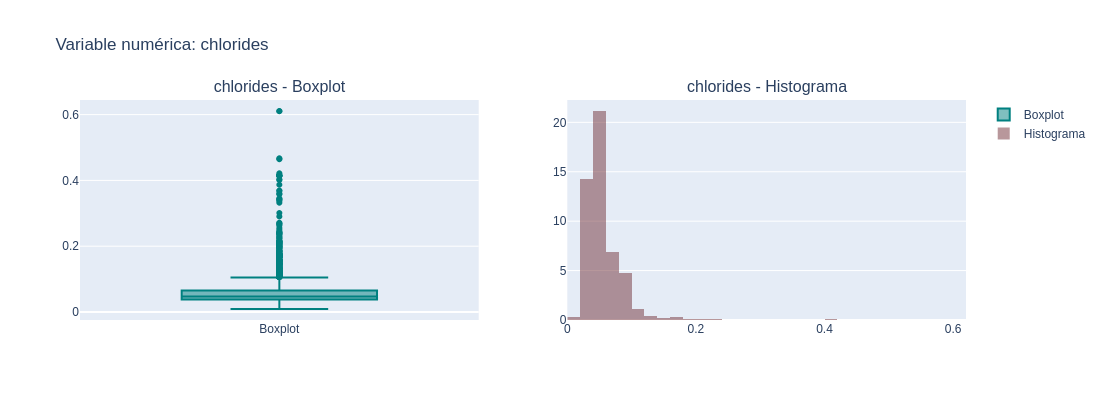

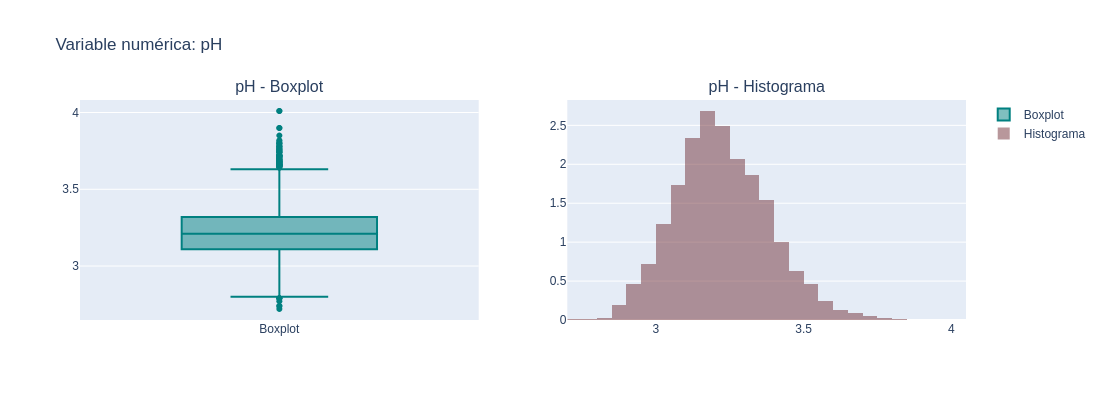

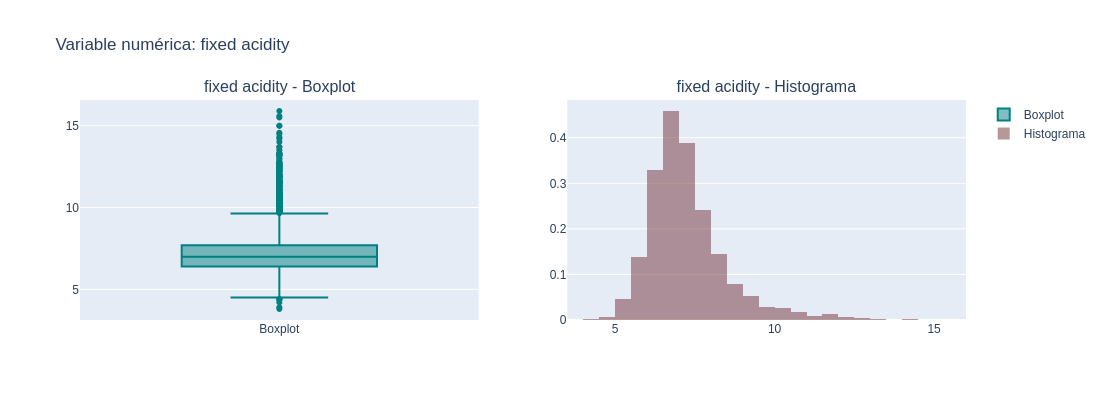

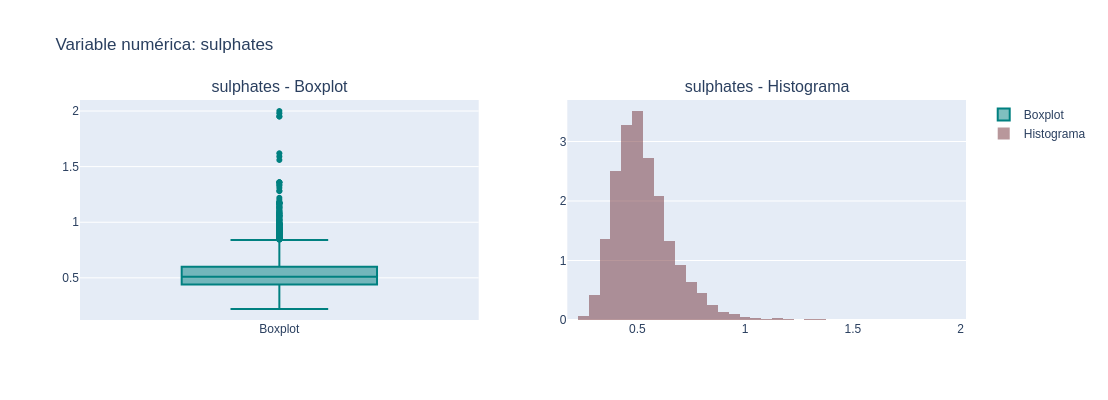

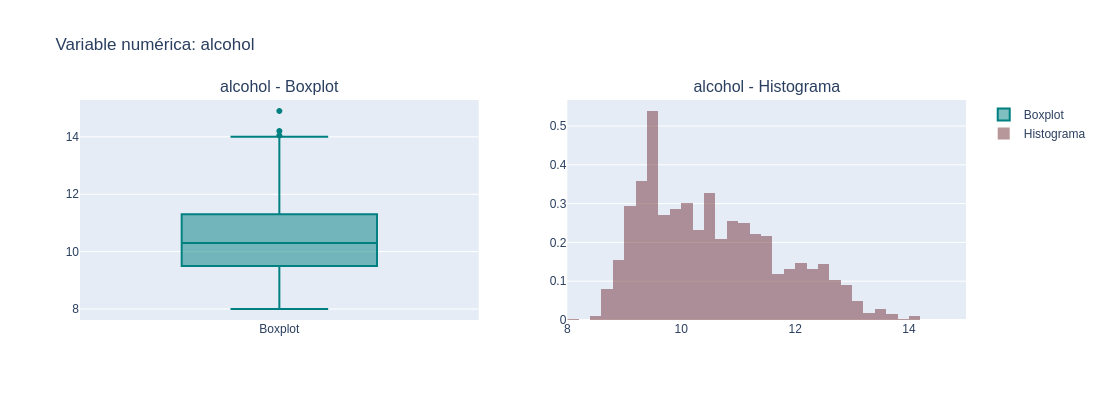

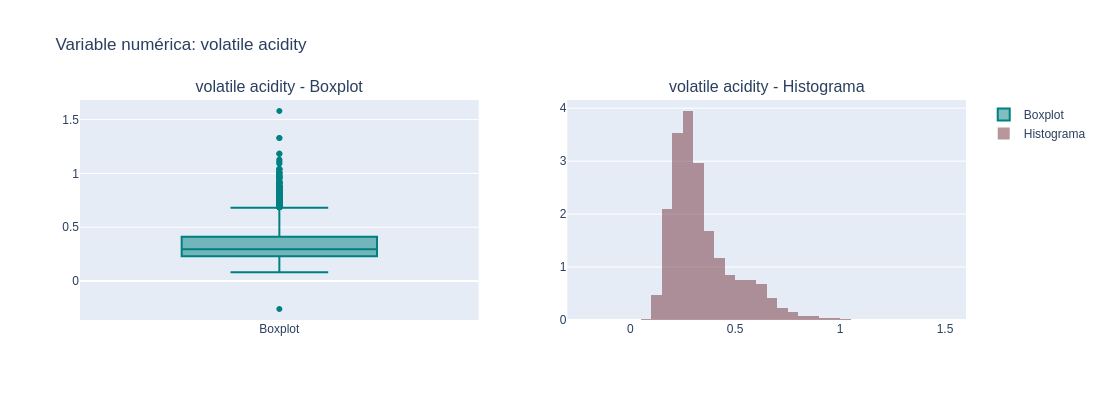

In [167]:
analisis.plot_num()

### Valores Atípicos

In [23]:
df_val_atipicos[['Variable', 'Unidad', 'Límite Inf', 'Límite Sup', 'Valores Atípicos']]

Variable  Unidad  Límite Inf  Límite Sup  Valores Atípicos
0          fixed acidity   g/dm³       4.000      15.000                 5
1       volatile acidity   g/dm³       0.120       1.100                31
2            citric acid   g/dm³       0.000       1.000                 1
3         residual sugar   g/dm³       0.600      65.000                 1
4              chlorides   g/dm³       0.009       0.346                18
5    free sulfur dioxide  mg/dm³       1.000      72.000                92
6   total sulfur dioxide  mg/dm³       6.000     440.000                 0
7                density   g/cm³       0.990       1.004               348
8                     pH       -       2.900       3.900                79
9              sulphates   g/dm³       0.220       1.080                35
10               alcohol     vol       8.000      14.900                 0
11               quality       -       3.000       9.000                 0

**Variable Chlorides**

Aunque en el gráfico de boxplot de la variable chlorides pareciera que hay muchos puntos atípicos, si tomamos en cuenta el rango normal de la variable (valores entre 0.009 y 0.346), en realidad solo se identifican 18 valores fuera de este rango, lo cual es un número reducido en comparación con lo que sugiere el gráfico.

In [24]:
print("Valores atípicos en la variable chlorides:", imputed_df[(imputed_df['chlorides'] < 0.009) | (imputed_df['chlorides'] > 0.346)].shape[0])

Valores atípicos en la variable chlorides: 18


**Variable Density**

In [25]:
print("Valores atípicos en la variable density:", imputed_df[(imputed_df['density'] < 0.99) | (imputed_df['density'] > 1.004)].shape[0])

Valores atípicos en la variable density: 348


In [26]:
percentiles = [0, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99, 100]

valores = np.percentile(imputed_df['density'], percentiles)

percentiles_df = pd.DataFrame(data = [valores], columns = percentiles)

display(percentiles_df)

0        1       5        10      20      30      40       50   \
0  0.98711  0.98892  0.9899  0.99067  0.9918  0.9928  0.9938  0.99489   

       60       70      80      90        95      99       100  
0  0.99568  0.99655  0.9974  0.9984  0.999392  1.0006  1.03898

In [27]:
percentiles = np.arange(5, 10.5, 0.5)  # incluimos 10

valores = np.percentile(imputed_df['density'], percentiles)

percentiles_df = pd.DataFrame(data = [valores], columns = percentiles)

display(percentiles_df)

5.0   5.5       6.0       6.5      7.0      7.5     8.0       8.5   \
0  0.9899  0.99  0.990078  0.990182  0.99022  0.99031  0.9904  0.990472   

      9.0     9.5      10.0  
0  0.99058  0.9906  0.99067

Vemos que un 5.5% de la muestra se acumula por debajo del valor mínimo esperado, 345 de los 348 valores atípicos observados anteriormente, el resto son valores mayores a 1.004.

In [28]:
imputed_df[imputed_df['density'] < np.percentile(imputed_df['density'], 5.5)].shape[0]

345

Density es la variable con más valores atípicos, sin embargo, tomando en cuenta que los valores por debajo del valor mínimo esperado se encuentran cerca de éste, entonces más adelante podemos considerar si los mantenemos como parte de la muestra.

**Detección de outliers**

In [215]:
#Detectar
def detect_outliers_iforest(df, n_estimators=100, contamination=0.01, random_state=1989):
    model = IForest(n_estimators=n_estimators, contamination=contamination, random_state=random_state)
    model.fit(df.values)
    preds = model.predict(df.values)
    return df[preds == 1]

In [216]:
df_outliers = detect_outliers_iforest(imputed_df[var_num])

In [217]:
N = imputed_df.shape[0] # Filas del dataframe original

In [218]:
n_outliers = df_outliers.shape[0] # Outliers

In [219]:
prop = n_outliers / N
print(f"Proporción de valores atípicos: {prop:.6%}")

Proporción de valores atípicos: 1.000462%


In [220]:
df_val_atipicos[['Variable', 'Unidad', 'Límite Inf', 'Límite Sup', 'Valores Atípicos']]

Variable  Unidad  Límite Inf  Límite Sup  Valores Atípicos
0          fixed acidity   g/dm³       4.000      15.000                 5
1       volatile acidity   g/dm³       0.120       1.100                31
2            citric acid   g/dm³       0.000       1.000                 1
3         residual sugar   g/dm³       0.600      65.000                 1
4              chlorides   g/dm³       0.009       0.346                18
5    free sulfur dioxide  mg/dm³       1.000      72.000                92
6   total sulfur dioxide  mg/dm³       6.000     440.000                 0
7                density   g/cm³       0.990       1.004               348
8                     pH       -       2.900       3.900                79
9              sulphates   g/dm³       0.220       1.080                35
10               alcohol     vol       8.000      14.900                 0
11               quality       -       3.000       9.000                 0

In [221]:
df_outliers.describe().loc[['min', '25%', '50%', '75%', 'max'],:]

citric acid  total sulfur dioxide  quality  residual sugar  density  \
min     -0.28288            -19.857417      3.0       -0.481195  0.98722   
25%      0.37000             19.000000      5.0        1.800000  0.99656   
50%      0.51000             50.637246      5.0        2.200000  0.99830   
75%      0.67000             77.000000      6.0        5.200000  1.00080   
max      1.00000            243.000000      8.0       65.800000  1.03898   

     free sulfur dioxide  chlorides    pH  fixed acidity  sulphates  alcohol  \
min                  3.0      0.009  2.74       4.200000       0.34      8.4   
25%                  6.0      0.075  3.00       7.700000       0.73      9.3   
50%                 12.0      0.122  3.08       8.600000       0.84      9.8   
75%                 22.0      0.358  3.22      11.803205       1.08     11.8   
max                 96.0      0.611  3.72      15.900000       2.00     14.9   

     volatile acidity  
min          0.157151  
25%          0.410000  
50%          0.532023  
75%          0.645000  
max          1.580000

De la tabla anterior vemos que la mayoría de los valores se encuentran en el rango normal de cada variable, los que si están fuera de lo normal son los valores negativos de las variables residual sugar, total sulfur dioxide, citric acid. Además como ya veíamos los valores arriba de 0.346 de la variable chlorides.

In [222]:
new_n_outliers = df_outliers[(df_outliers['chlorides'] > 0.346) | (df_outliers['citric acid'] < 0) | (df_outliers['residual sugar'] < 0.6) | (df_outliers['total sulfur dioxide'] < 6) | (df_outliers['density'] < 0.99)].shape[0]

In [223]:
#Eliminamos esos valores (0.4% de la muestra)
df_clean = imputed_df.drop(df_outliers.index)

In [224]:
# Quitando valores atípicos que salen por el método Isolation Forest
print("Dimensión anterior:", N, ", nueva dimensión:", df_clean.shape[0])

Dimensión anterior: 6497 , nueva dimensión: 6432


In [225]:
# Si quitáramos valores atípicos de la variable density y de los valores atípicos que vemos con el método Isolation Forest
print("Dimensión anterior:", N, ", nueva dimensión:", N-imputed_df[(imputed_df['chlorides'] > 0.346) | (imputed_df['citric acid'] < 0) | (imputed_df['residual sugar'] < 0.6) | (imputed_df['total sulfur dioxide'] < 6) | (imputed_df['density'] < 0.99)].shape[0])

Dimensión anterior: 6497 , nueva dimensión: 6113


**Variable Quality**

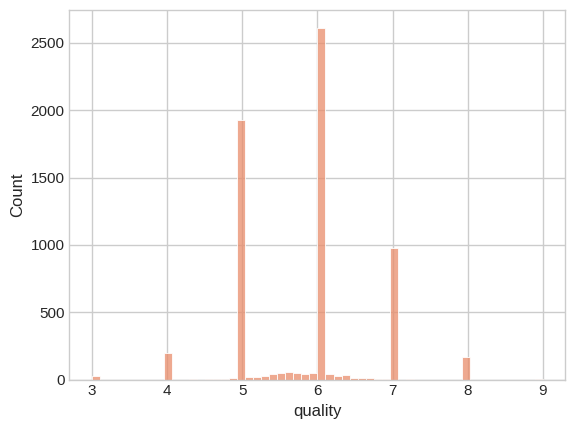

In [226]:
sns.histplot(df_clean['quality'])
plt.show()

In [248]:
decimales_num = (df_clean['quality'].astype(str).str.split('.', expand=True)[1].astype(int) != 0).sum()

print('Valores con decimales:', decimales_num)
print('Proporción con decimales:', '{0:.2%}'.format(decimales_num/N))

Valores con decimales: 585
Proporción con decimales: 9.00%


In [249]:
df_clean['quality'] = df_clean['quality'].astype(int)

In [260]:
df_clean['quality'].value_counts(normalize=True).sort_index().apply(lambda x: '{0:.2%}'.format(x))

quality
3     0.36%
4     3.44%
5    35.34%
6    42.94%
7    15.22%
8     2.64%
9     0.06%
Name: proportion, dtype: object

Los valores decimales de **quality** fueron ajustados a enteros con el fin de mantener consistencia con la definición original de la variable y facilitar el análisis estadístico.

## 3.- Describe estadísticamente cada variable del conjunto de datos y anota las observaciones relevantes con respecto a la tendencia central y dispersión.

In [309]:
df_clean.describe().loc[['count','mean','std','min','25%','50%','75%','max'],:].T

count        mean        std       min      25%  \
fixed acidity         6432.0    7.193687   1.223717  3.800000   6.4000   
volatile acidity      6432.0    0.338015   0.156232 -0.261265   0.2300   
citric acid           6432.0    0.316696   0.138871  0.000000   0.2500   
residual sugar        6432.0    5.441123   4.689957 -3.297837   1.8000   
chlorides             6432.0    0.054610   0.027977  0.012000   0.0380   
free sulfur dioxide   6432.0   30.635570  17.572140 -0.813248  17.0000   
total sulfur dioxide  6432.0  115.884746  55.286548 -2.687222  79.0000   
density               6432.0    0.994657   0.002920  0.987110   0.9923   
pH                    6432.0    3.219208   0.159258  2.720000   3.1100   
sulphates             6432.0    0.527886   0.138147  0.220000   0.4400   
alcohol               6432.0   10.493772   1.182627  8.000000   9.5000   
quality               6432.0    5.774098   0.857682  3.000000   5.0000   

                             50%        75%       max  
fixed acidity           7.000000    7.70000   15.0000  
volatile acidity        0.290454    0.40000    1.3300  
citric acid             0.310000    0.39000    1.6600  
residual sugar          3.100000    8.10000   31.6000  
chlorides               0.047000    0.06400    0.3690  
free sulfur dioxide    29.000000   41.00000  289.0000  
total sulfur dioxide  119.000000  155.00000  440.0000  
density                 0.994815    0.99691    1.0103  
pH                      3.210000    3.32000    4.0100  
sulphates               0.502864    0.60000    1.9800  
alcohol                10.300000   11.30000   14.2000  
quality                 6.000000    6.00000    9.0000

* **El 76% de la muestra corresponden a vinos blancos.**

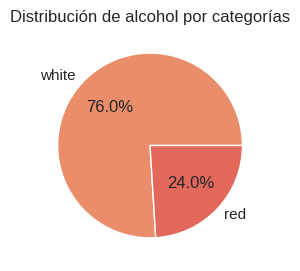

In [310]:
df_clean['type'].value_counts().plot.pie(
    autopct='%1.1f%%',
    figsize=(3,3),
    #colors=sns.color_palette("Set2"),
    title="Distribución de alcohol por categorías"
)
plt.ylabel("")  # quita la etiqueta del eje y
plt.show()

* **El porcentaje de alcohol de los vinos se concentra en 10% y el 15% (media del 10%).**

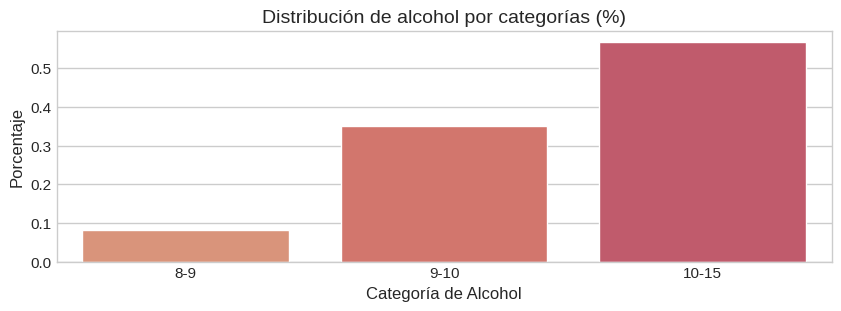

In [311]:
# Definir los bordes de los intervalos
bins = [8, 9, 10, 15]
labels = ['8-9', '9-10', '10-15']

# Crear variable categórica ordenada
df_clean['alcohol_cat'] = pd.cut(
    df_clean['alcohol'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True,
    ordered=True
)

# Calculamos porcentajes
counts = df_clean['alcohol_cat'].value_counts(normalize=True).reset_index()
counts.columns = ['categoria', 'porcentaje']

plt.figure(figsize=(10,3))
sns.barplot(
    x="categoria", 
    y="porcentaje", 
    hue="categoria",       # aquí usamos hue
    data=counts, 
    #palette="Set2", 
    legend=False           # quitamos la leyenda duplicada
)

plt.title("Distribución de alcohol por categorías (%)", fontsize=14)
plt.xlabel("Categoría de Alcohol")
plt.ylabel("Porcentaje")
plt.show()

* **La mediana del pH se asimila con la media (3.22) y tiene una distribución casi simétrica. El valor de la media bajo hace sentido con los vinos, ya que tienen pH bajos (baja acidez).**

a) Media: 3.2192 
b) Desviación Estándar: 0.1593 
c) Mediana: 3.2100 



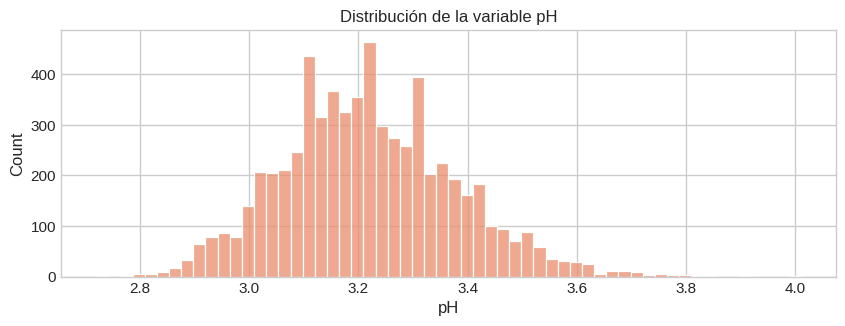

In [312]:
pH = df_clean['pH']

print('a) Media:', '{0:.4f}'.format(pH.mean()), 
      '\n'+'b) Desviación Estándar:', '{0:.4f}'.format(pH.std()),
      '\n'+'c) Mediana:', '{0:.4f}'.format(pH.quantile(0.5)), '\n')

plt.figure(figsize=(10,3.2))
sns.histplot(pH)
plt.title('Distribución de la variable pH')
plt.show()

* **La calidad de los vinos se concentra en el rango de 5 a 7, lo cual hace sentido con la media de 5.7.**

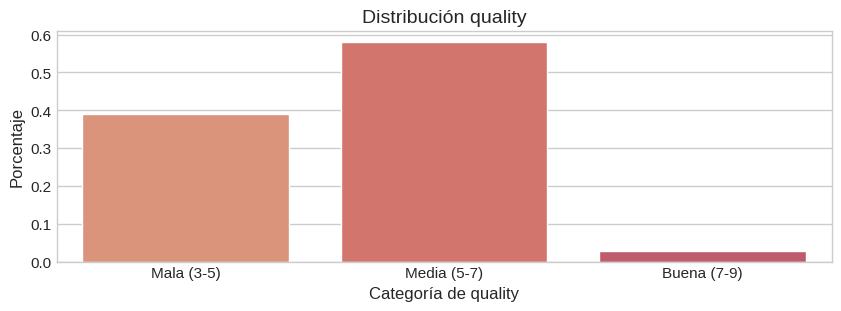

In [333]:
# Definir los bordes de los intervalos
bins = [3, 5, 7, 9]
labels = ['Mala (3-5)', 'Media (5-7)', 'Buena (7-9)']

# Crear variable categórica ordenada
df_clean['quality_cat'] = pd.cut(
    df_clean['quality'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True,
    ordered=True
)

# Calculamos porcentajes
counts = df_clean['quality_cat'].value_counts(normalize=True).reset_index()
counts.columns = ['categoria', 'porcentaje']

plt.figure(figsize=(10,3))
sns.barplot(
    x="categoria", 
    y="porcentaje", 
    hue="categoria",       # aquí usamos hue
    data=counts, 
    #palette="Set2", 
    legend=False           # quitamos la leyenda duplicada
)

plt.title("Distribución quality", fontsize=14)
plt.xlabel("Categoría de quality")
plt.ylabel("Porcentaje")
plt.show()

## 4.- Realiza una comparativa de variables con respecto al tipo de vinos de tu interés. Por ejemplo, ¿Los vinos tintos tienen más acidez fija que los blancos?

### ¿La relación entre el azúcar residual y la densidad es diferente entre vinos tintos y blancos?

En los vinos blancos se observa una mayor cantidad de azúcar residual, lo que incrementa su densidad y favorece su perfil como vinos más dulces. En contraste, los vinos tintos suelen presentar un contenido mucho menor de azúcar residual, lo que los caracteriza como vinos más secos.

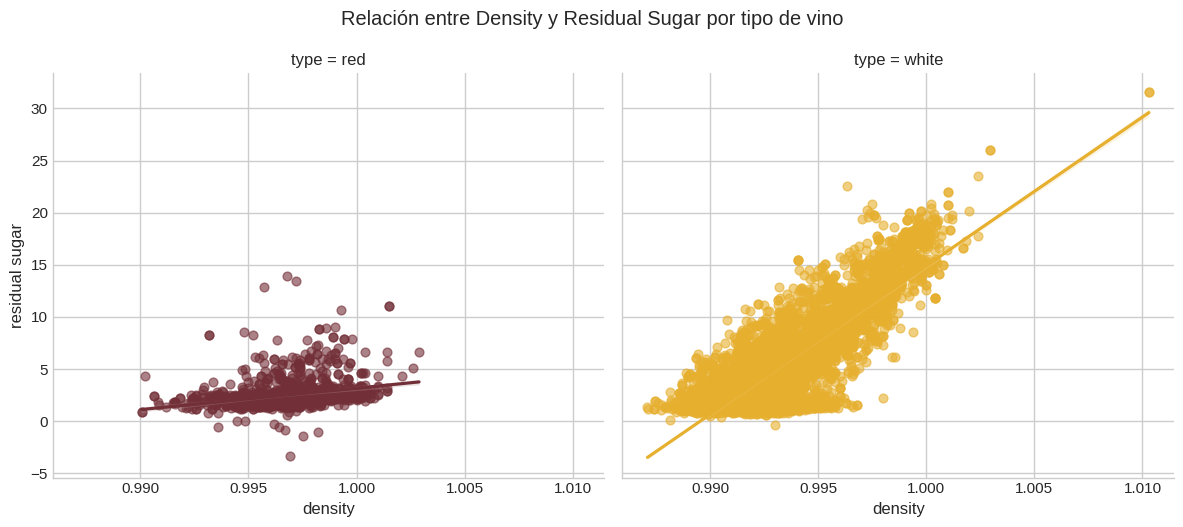

In [314]:
palette = {"red": "#722F37", "white": "#E6AF2E"}  # burdeos y dorado

sns.lmplot(
    data=df_clean,
    x="density", y="residual sugar",
    col="type", hue="type",             # <-- clave
    palette=palette, legend=False,
    height=5, aspect=1.2,
    scatter_kws={"alpha":0.6, "s":40},
)
plt.suptitle("Relación entre Density y Residual Sugar por tipo de vino", y=1.05)
plt.show()


### ¿Los vinos tintos tienen más acidez fija que los blancos?

Los resultados muestran que los vinos tintos presentan en promedio una mayor acidez fija que los blancos, lo que se traduce en sabores más intensos, estructura y mayor potencial de guarda. En contraste, los vinos blancos, al tener una acidez fija más baja, tienden a ser más frescos, ligeros y fáciles de beber.

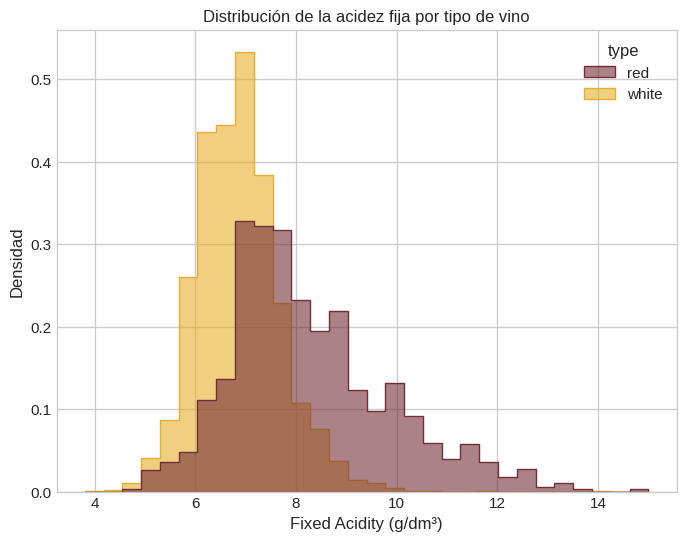

In [315]:
plt.figure(figsize=(8,6))
sns.histplot(
    data=df_clean,
    x="fixed acidity",     # o "volatile acidity"
    hue="type",            # separa por tipo de vino
    palette={"red": "#722F37", "white": "#E6AF2E"},
    element="step",        # estilo de línea, más claro para comparar
    stat="density",        # normaliza para comparar distribuciones
    common_norm=False,     # cada grupo con su propia escala
    bins=30,               # número de intervalos
    alpha=0.6
)

plt.title("Distribución de la acidez fija por tipo de vino")
plt.xlabel("Fixed Acidity (g/dm³)")
plt.ylabel("Densidad")
plt.show()

## P5.- Realiza un análisis de las variables con respecto a la calidad del vino. ¿Los vinos de mejor calidad tienen más alcohol, más acidez fija, menor azúcar residual, etc.? (Hint. Puedes cortar y agrupar la calidad del vino en buena o mala o en mala, media, buena si crees que te ayudaría al análisis).

In [340]:
df_clean["quality_cat_word"] = df_clean["quality_cat"].str.split(' ', expand=True)[0] # categoría

df_clean["quality_cat_word"] = pd.Categorical(
    df_clean["quality_cat_word"],
    categories=["Mala", "Media", "Buena"],
    ordered=True
)

# 'count' en columna quality y en las demás los promedios
calidad = df_clean.groupby(["type", "quality_cat_word"], observed=True).agg(
    {col: "mean" for col in var_num} | {"quality": ["count", "mean"]}
)

# Renombrar columnas
calidad.columns = [f"{c[0]}_{c[1]}" if c[1] != "" else c[0] for c in calidad.columns]

calidad = calidad.loc[:, ['quality_count','quality_mean'] + list(set(calidad.columns)-set(['quality_count','quality_mean']))]

display(calidad)

quality_count  quality_mean  density_mean  \
type  quality_cat_word                                              
red   Mala                        759      4.899868      0.997000   
      Media                       775      6.220645      0.996394   
      Buena                        11      8.000000      0.995184   
white Mala                       1758      4.891354      0.995170   
      Media                      2966      6.272421      0.993429   
      Buena                       163      8.024540      0.992271   

                        fixed acidity_mean  total sulfur dioxide_mean  \
type  quality_cat_word                                                  
red   Mala                        8.085516                  53.917772   
      Media                       8.439671                  38.864763   
      Buena                       8.399915                  27.187680   
white Mala                        6.969070                 148.178199   
      Media                       6.799001                 132.470718   
      Buena                       6.639799                 126.517904   

                        volatile acidity_mean  citric acid_mean  \
type  quality_cat_word                                            
red   Mala                           0.582734          0.227546   
      Media                          0.475185          0.294831   
      Buena                          0.381890          0.387159   
white Mala                           0.305641          0.334231   
      Media                          0.262229          0.333961   
      Buena                          0.271557          0.327738   

                        sulphates_mean  residual sugar_mean  chlorides_mean  \
type  quality_cat_word                                                        
red   Mala                    0.608966             2.475470        0.085542   
      Media                   0.688838             2.498000        0.080276   
      Buena                   0.791035             2.600000        0.071364   
white Mala                    0.481559             7.047554        0.050825   
      Media                   0.494316             6.012345        0.043067   
      Buena                   0.477807             5.715693        0.038276   

                         pH_mean  alcohol_mean  free sulfur dioxide_mean  
type  quality_cat_word                                                    
red   Mala              3.317696      9.943609                 16.533689  
      Media             3.317755     10.876332                 15.408523  
      Buena             3.247275     11.893626                 14.363636  
white Mala              3.172726      9.841961                 35.371552  
      Media             3.195534     10.852667                 35.143117  
      Buena             3.222258     11.641565                 36.697153

In [ ]:
calidad.to_csv('~/Download/wine_agg_table.csv')

In [363]:
from pandas.api.types import CategoricalDtype

class analyze_by_cat:
    def __init__(self, df, num_vars, cat_vars):
        self.df = df
        self.num_vars = num_vars
        self.cat_vars = cat_vars

    # NUEVO: numéricas por categoría (cols) y hue=tipo (leyenda)
    def plot_num_by_cat(self, category_col="quality_cat_word", hue_col="type"):
        # respetar el orden de categoría si es Categorical
        if isinstance(self.df[category_col].dtype, CategoricalDtype):#pd.api.types.is_categorical_dtype(self.df[category_col]):
            cats = list(self.df[category_col].cat.categories)
        else:
            cats = list(pd.unique(self.df[category_col]))

        # colores por tipo de vino
        palette = {"red": "#722F37", "white": "#E6AF2E"}  # burdeos y dorado
        types = list(pd.unique(self.df[hue_col]))

        for var in self.num_vars:
            # 2 filas (Box / Hist), columnas = categorías
            fig = make_subplots(
                rows=2, cols=len(cats),
                subplot_titles=[f"{category_col}: {c}" for c in cats],
                shared_yaxes=True
            )

            for j, c in enumerate(cats, start=1):
                df_c = self.df[self.df[category_col] == c]

                for t in types:
                    df_ct = df_c[df_c[hue_col] == t]

                    # BOXPLOT (fila 1)
                    fig.add_trace(
                        go.Box(
                            y=df_ct[var],
                            name=t,
                            marker_color=palette.get(t, None),
                            boxmean="sd",
                            legendgroup=t,
                            showlegend=(j == 1),  # leyenda solo en la 1ª col
                            hovertemplate=f"{hue_col}: {t}<br>{var}: %{{y}}<extra></extra>"
                        ),
                        row=1, col=j
                    )

                    # HISTOGRAMA (fila 2)
                    fig.add_trace(
                        go.Histogram(
                            x=df_ct[var],
                            name=t,
                            marker_color=palette.get(t, None),
                            opacity=0.55,
                            nbinsx=40,
                            histnorm="probability density",
                            legendgroup=t,
                            showlegend=False,
                            hovertemplate=f"{hue_col}: {t}<br>{var}: %{{x}}<br>densidad: %{{y:.3f}}<extra></extra>"
                        ),
                        row=2, col=j
                    )

            fig.update_layout(
                title=f"{var}: Boxplot (arriba) + Histograma (abajo) por {category_col}",
                height=550, width=380*len(cats),
                barmode="overlay",  # histos superpuestos
                boxmode="group",
                margin=dict(t=80)
            )
            fig.update_xaxes(title_text=var, row=2)   # eje x solo en hist
            fig.update_yaxes(title_text=var, row=1)   # eje y box
            fig.update_yaxes(title_text="densidad", row=2)

            fig.show()

In [367]:
analisis = analyze_by_cat(df_clean, var_num, var_cat)

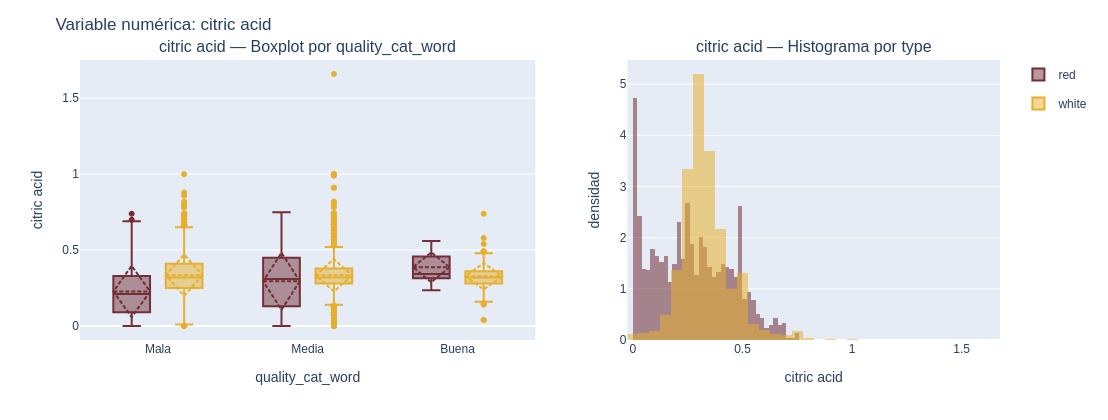

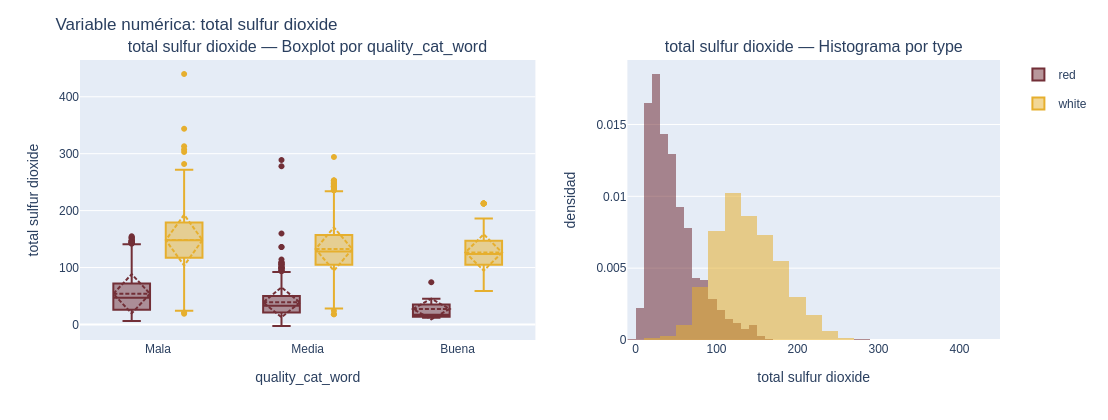

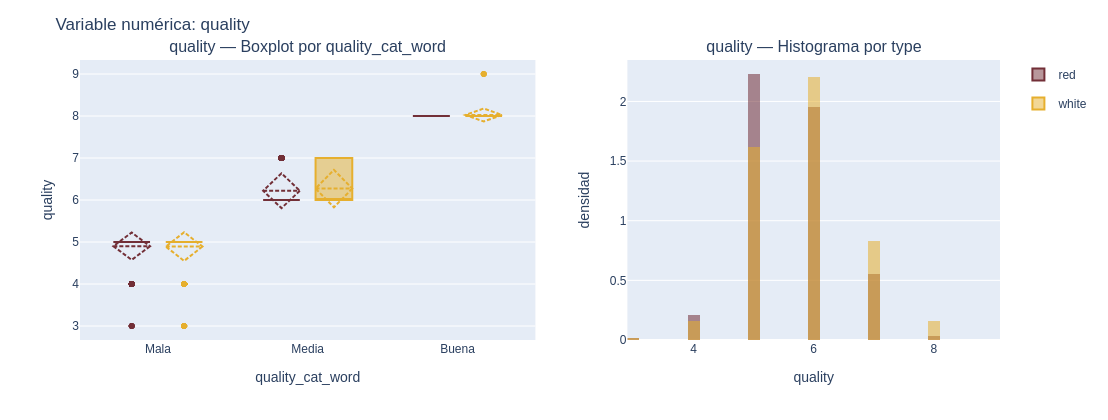

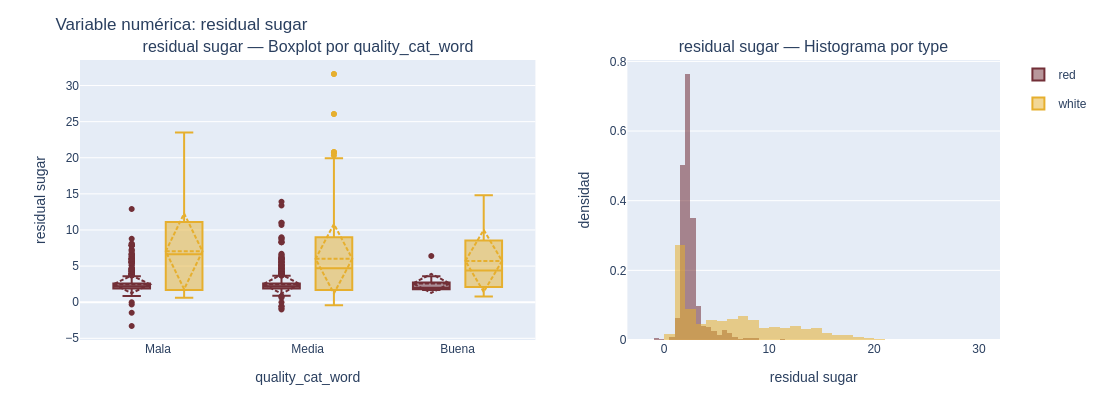

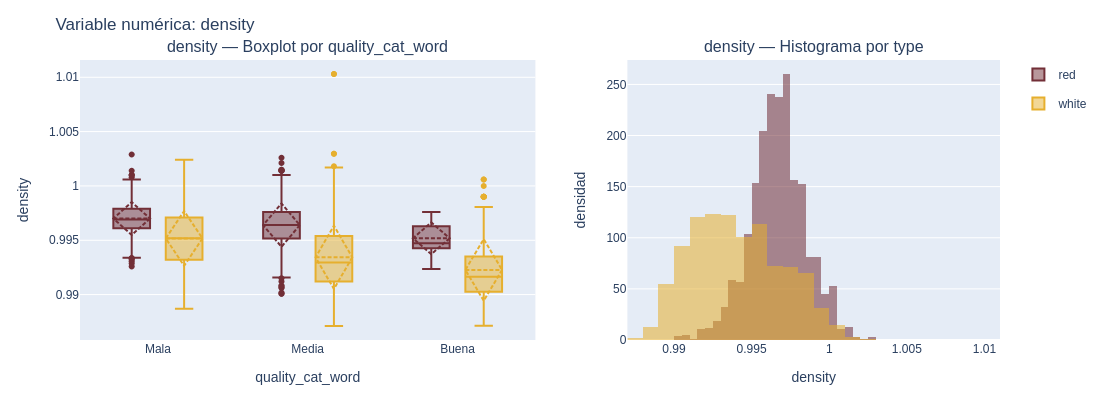

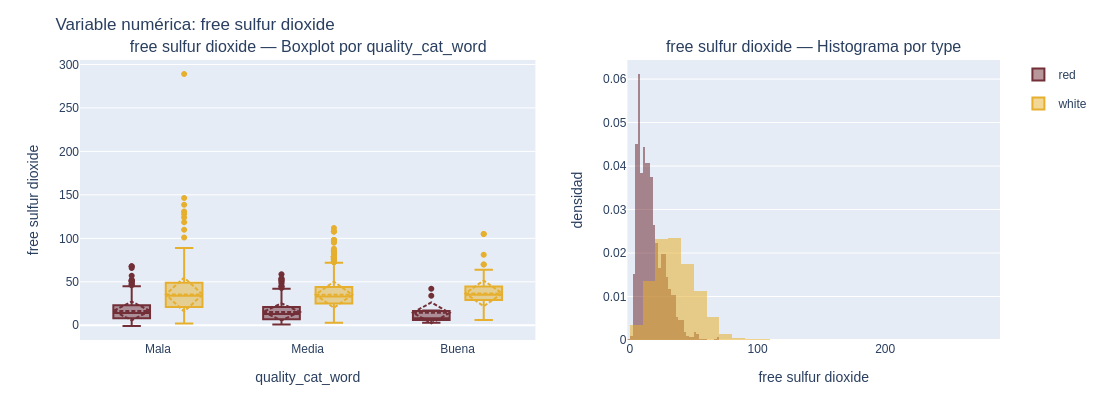

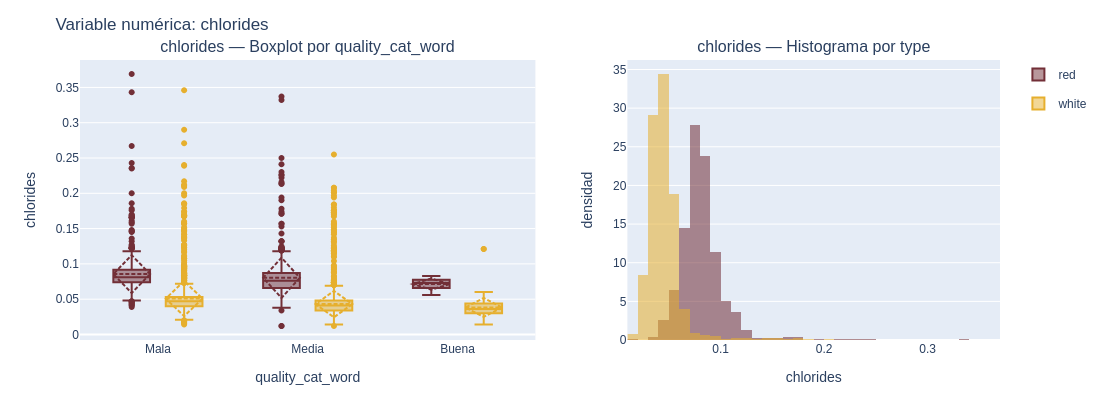

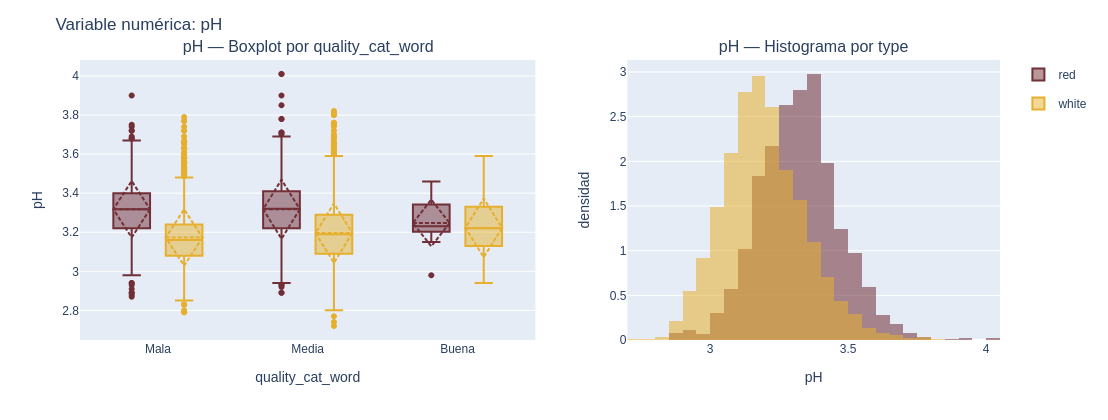

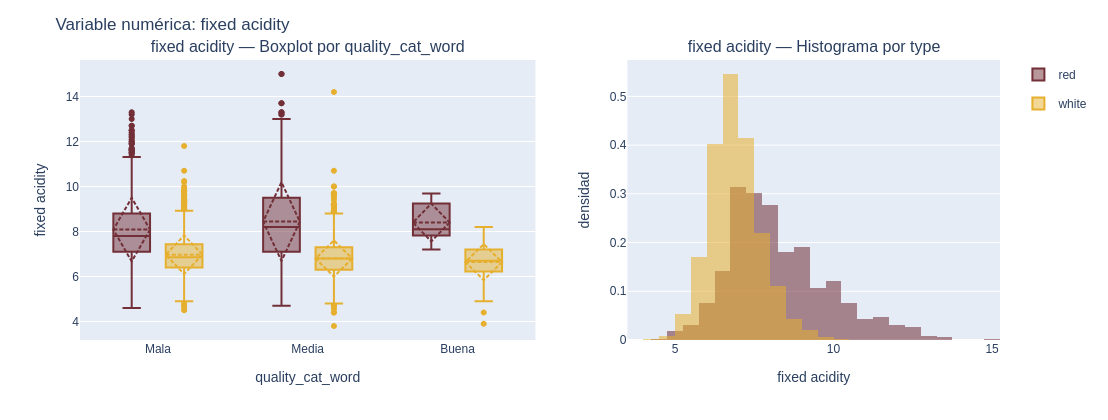

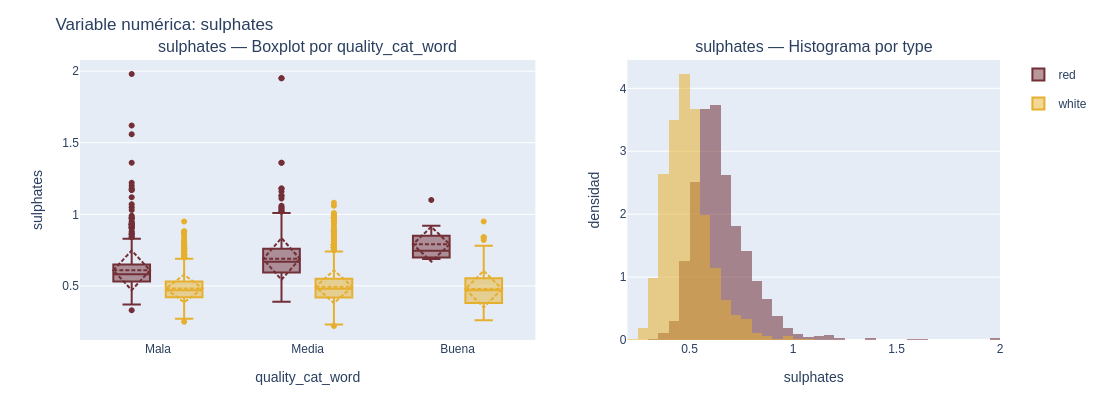

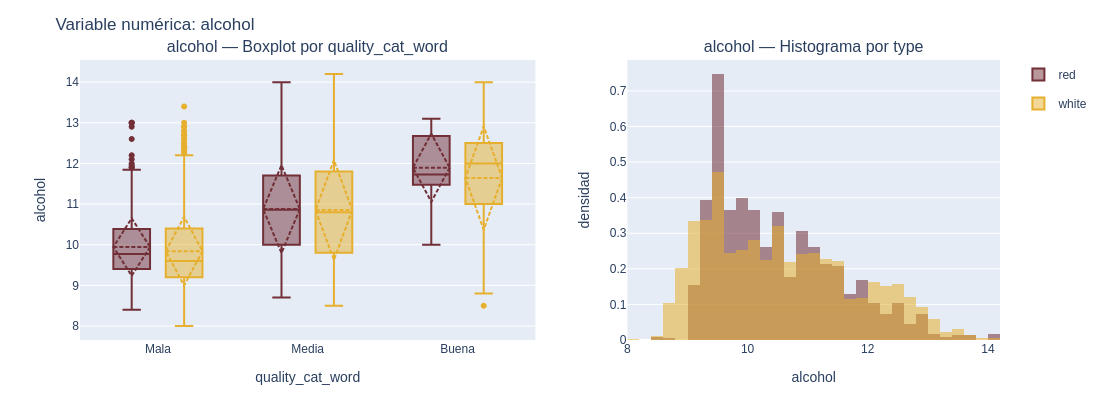

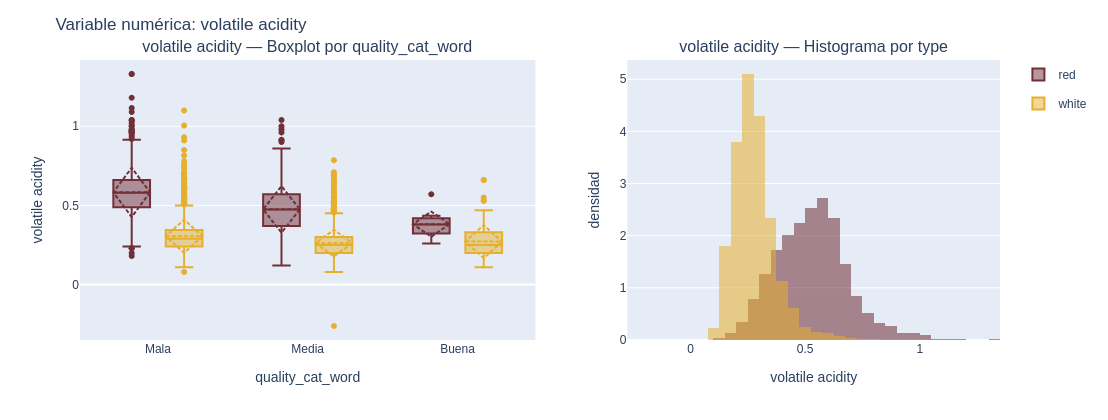

In [368]:
for v in analisis.num_vars:
    analisis.plot_box_hist_by_cat(v, "quality_cat_word", "type")

## P6.- Obtén la correlación de las variables y grafica su matriz. ¿Tiene sentido la correlación entre las variables? Explica el porqué sí o porqué no.

In [423]:
last_analisis = analyze(df_clean, var_num, var_cat)

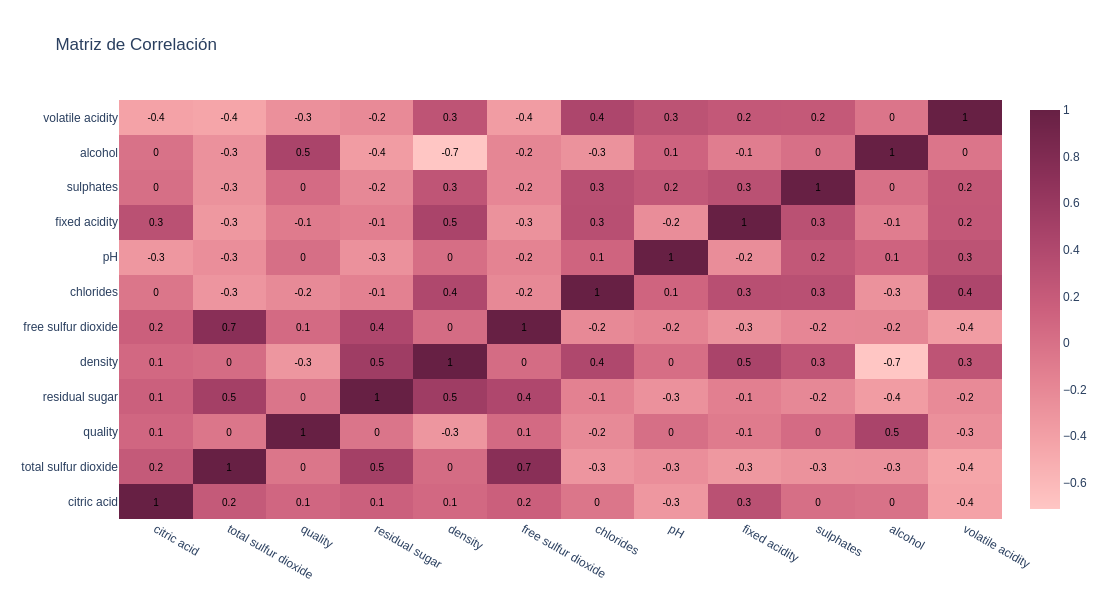

In [424]:
last_analisis.corr_matrix('burg')

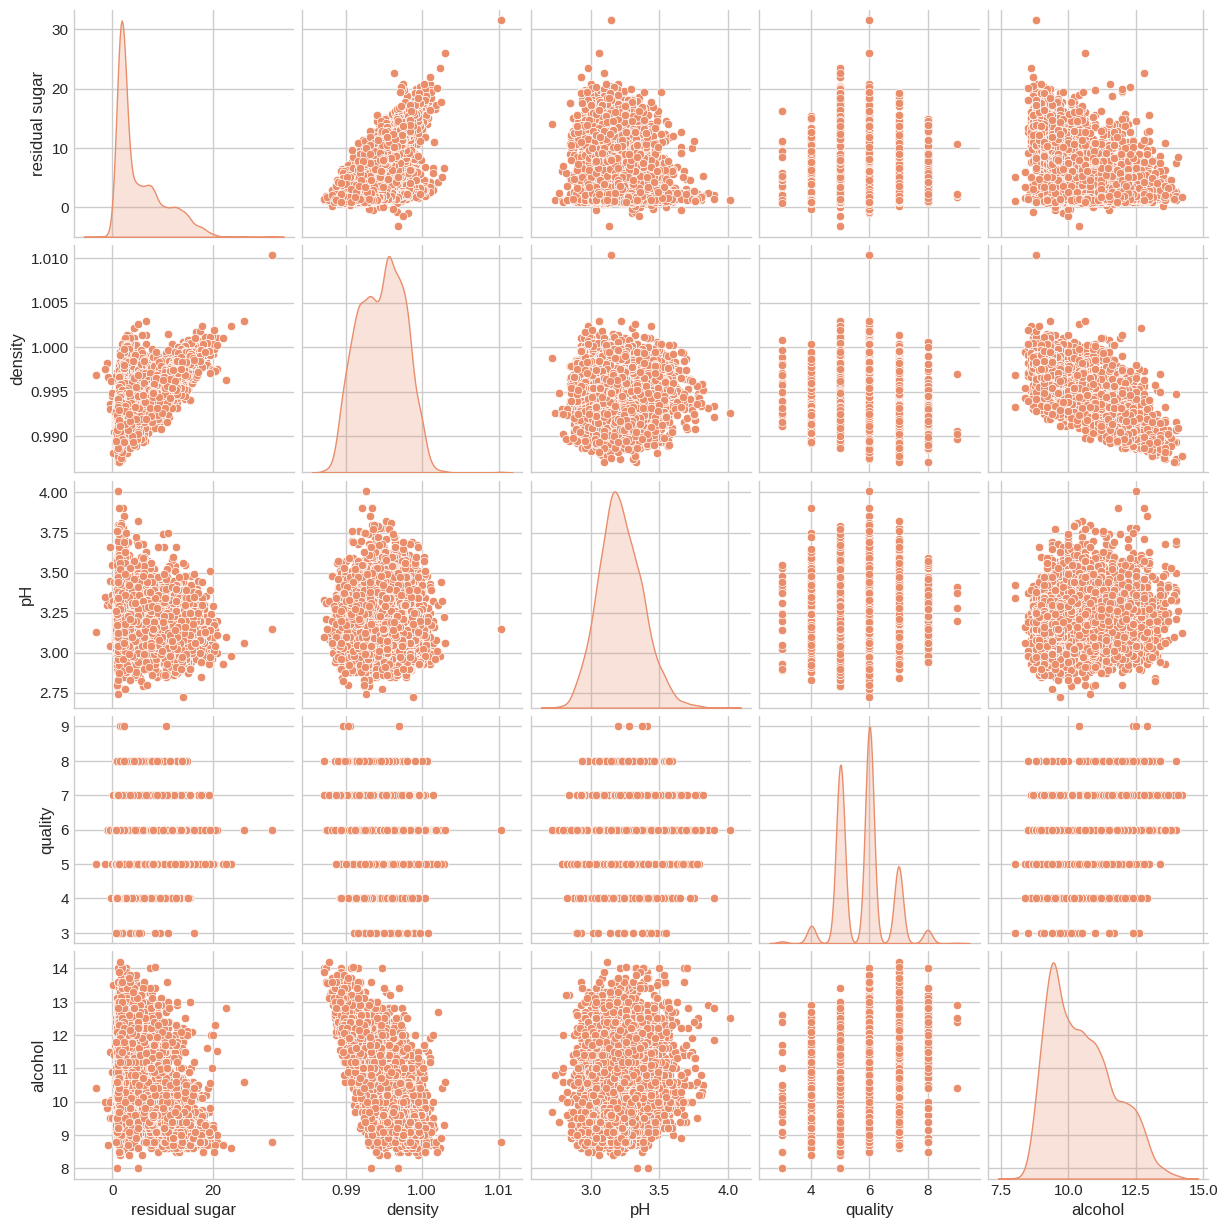

In [409]:
sns.pairplot(df_clean.loc[:,['residual sugar', 'density', 'pH', 'quality', 'alcohol']], diag_kind="kde")
plt.show()